In [54]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso 

/var/folders/2g/lgqxddy17rb530lgfvfz7dl40000gn/T/ipykernel_1078/2973297191.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain = imread('../reference_material/oslo.tif')


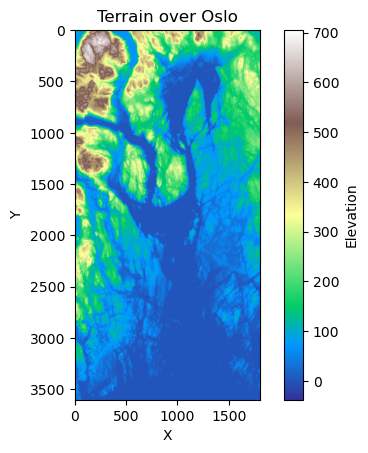

In [106]:
COLORMAP = "terrain"  # color map for countour plots

# Load the terrain
terrain = imread('../reference_material/oslo.tif')
# Show the terrain
plt.figure()
plt.title('Terrain over Oslo')
plt.imshow(terrain, cmap=COLORMAP)
plt.colorbar(label="Elevation [m]")
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [56]:
def create_X(x, y, n):
    """Returns the design matrix X from coordinates x and y with n polynomial degrees."""
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n + 1) * (n + 2) / 2)  # Number of elements in beta
    X = np.ones((N, l))

    for i in range(1, n + 1):
        q = int(i * (i + 1) / 2)
        for k in range(i + 1):
            X[:, q + k] = (x**(i - k)) * (y**k)

    return X

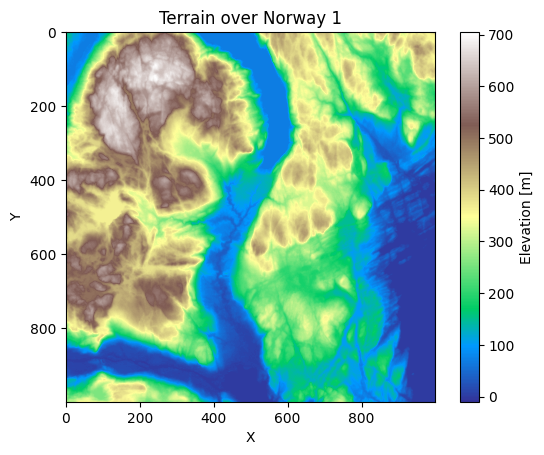

In [15]:
"""Extracting a square piece of the terrain"""

N = 1000
# Creates mesh of image pixels
x = np.linspace(0,1, np.shape(terrain)[0])
y = np.linspace(0,1, np.shape(terrain)[1])
x_mesh, y_mesh = np.meshgrid(x,y)

z = terrain[:N,:N]
#X = create_X(x_mesh, y_mesh,5)


# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain, cmap=COLORMAP)
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label="Elevation [m]")
plt.show()

In [16]:
terrain.shape

(1000, 1000)

Text(0.5, 0, 'Elevation [m]')

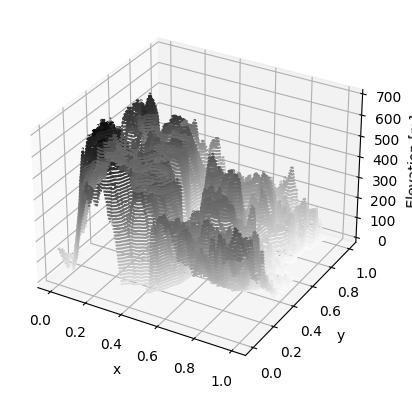

In [17]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(x, y, z, 50, cmap="binary")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Elevation [m]')

In [18]:
z.reshape(-1,1)

Array([[148],
       [148],
       [149],
       ...,
       [  0],
       [  0],
       [  0]], dtype=int16)

# ***testing...***

In [19]:
# Creates mesh of image pixels
x = np.linspace(0, 1, np.shape(terrain)[0])
y = np.linspace(0, 1, np.shape(terrain)[1])
x_mesh, y_mesh = np.meshgrid(x,y)
z = terrain[:N,:N]
degrees = [6]


# Iterate through all the different polynomial degrees
for degree in degrees:
    # tell the model what degree of polynomial we want
    polynomial_model = PolynomialFeatures(degree)

    # use the package to create a design matrix for a second degree polynomial
    # by converting x to a column vector 
    X = polynomial_model.fit_transform(x_mesh.ravel())

    # Split in training and test data up to the given degree
    X_train, X_test, z_train, z_test = train_test_split(X, z.ravel(), test_size=0.2)


ValueError: Expected 2D array, got 1D array instead:
array=[0.       0.001001 0.002002 ... 0.997998 0.998999 1.      ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

# Implementing task a) to terrain data

In [192]:



def MSE(y_actual, y_model):
    """Returns the mean squared error of the two arrays."""
    y_actual, y_model = y_actual.ravel(), y_model.ravel()  # flatten arrays
    return np.mean((y_actual - y_model)**2)


def R2_score(y_actual, y_model):
    """Returns the R2 score of the two arrays."""
    y_actual, y_model = y_actual.ravel(), y_model.ravel()  # flatten arrays
    return 1 - np.sum((y_actual - y_model)**2) / np.sum((y_actual - np.mean(y_actual))**2)


# PARAMETERS
N = 1000  # number of data points
maxdegree = 10  # max polynomial degree for plotting

"""
# Figure output directory
RESULTS_DIR = Path("../results").resolve()
FIGURES_DIR = RESULTS_DIR / "figures"

# Create them if they dont exist
if not RESULTS_DIR.exists():
    RESULTS_DIR.mkdir()

if not FIGURES_DIR.exists():
    FIGURES_DIR.mkdir()
"""
# Creates mesh of image pixels
x = np.linspace(0, 1, np.shape(terrain)[0])
y = np.linspace(0, 1, np.shape(terrain)[1])
x_mesh, y_mesh = np.meshgrid(x,y)
z = terrain[:N, :N]
# z = terrain.reshape(-1,1)
# x_mesh = x_mesh.reshape(-1,1)   ###### Lasse: ?? nå har x_mesh og y_mesh forskjellige sizes, gir ikke mening/ ikke tenk på det - Parham

# Initialize scaler
scaler = StandardScaler()

degrees = np.arange(0, maxdegree, 1)
train_mse = np.empty(degrees.shape)
test_mse = np.empty_like(train_mse)
train_r2 = np.empty_like(train_mse)
test_r2 = np.empty_like(train_mse)

# Iterate through all the different polynomial degrees
for degree in degrees:
    # tell the model what degree of polynomial we want
    polynomial_model = PolynomialFeatures(degree)

    # use the package to create a design matrix for a second degree polynomial
    # by converting x to a column vector 
    X = polynomial_model.fit_transform(x_mesh, y_mesh)

    # Split in training and test data up to the given degree
    X_train, X_test, z_train, z_test = train_test_split(X, z.ravel(), test_size=0.3)

    # Scale data
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Ordinary least squares linear regression
    beta = np.linalg.pinv(X_train_scaled.T @ X_train_scaled) @ X_train_scaled.T @ z_train
    z_tilde = X_train_scaled @ beta
    z_predict = X_test_scaled @ beta
    
    # Store the MSE and R2 values
    train_mse[degree] = MSE(z_train, z_tilde)
    test_mse[degree] = MSE(z_test, z_predict)
    train_r2[degree] = R2_score(z_train, z_tilde)
    test_r2[degree] = R2_score(z_test, z_predict)

ValueError: Found input variables with inconsistent numbers of samples: [1000, 1000000]

In [193]:
np.sqrt(300000)

547.7225575051662

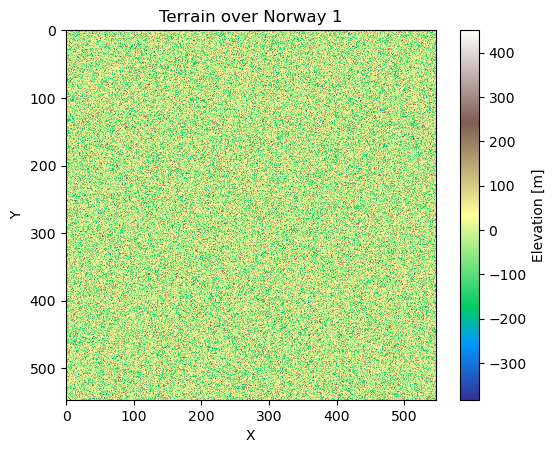

In [190]:
z_predict_reshaped = z_predict[:299209]
z_predict_reshaped = z_predict_reshaped.reshape(547,547)

# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(z_predict_reshaped, cmap=COLORMAP)
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label="Elevation [m]")
plt.show()

(547, 547)

Text(0, 0.5, 'MSE')

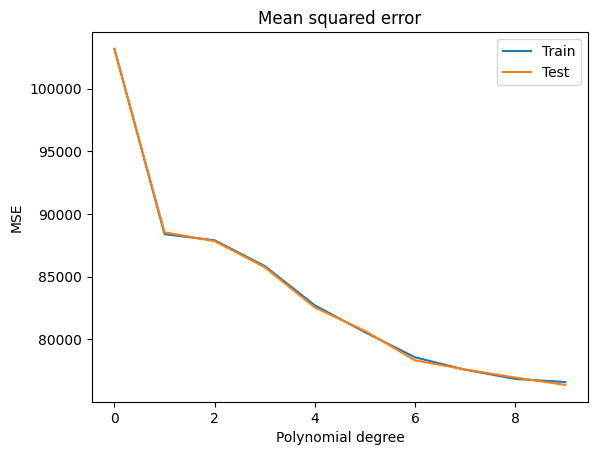

In [23]:
# Plot the MSE as function of poly. degree
plt.figure()
plt.plot(degrees, train_mse, label="Train")
plt.plot(degrees, test_mse, label="Test")
plt.legend()
plt.title("Mean squared error")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
# plt.savefig(FIGURES_DIR / "part_g_MSE.png")

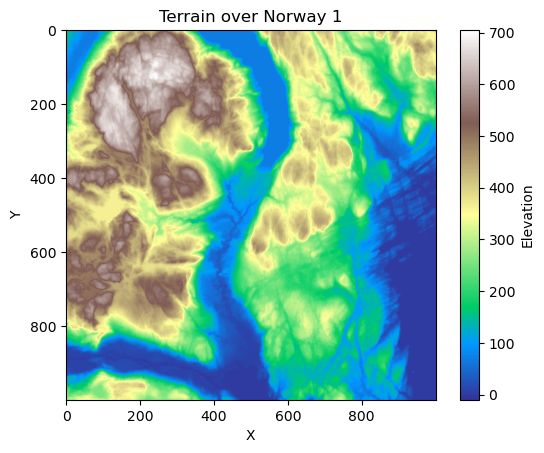

In [108]:
x = np.linspace(0,1, np.shape(terrain)[0])
y = np.linspace(0,1, np.shape(terrain)[1])
x_mesh, y_mesh = np.meshgrid(x,y)

z = terrain
#X = create_X(x_mesh, y_mesh,5)

# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain, cmap=COLORMAP)
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label="Elevation [m]")
plt.show()

Text(0, 0.5, 'MSE')

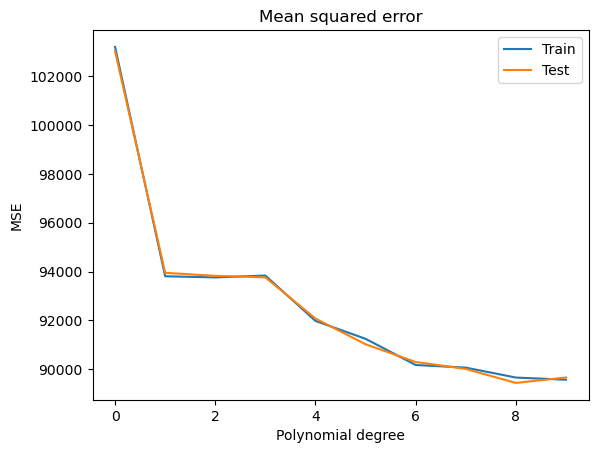

In [63]:
# Plot the MSE as function of poly. degree
plt.figure()
plt.plot(degrees, train_mse, label="Train")
plt.plot(degrees, test_mse, label="Test")
plt.legend()
plt.title("Mean squared error")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
#plt.savefig(FIGURES_DIR / "part_a_MSE.png")

Text(0, 0.5, '$R^2$')

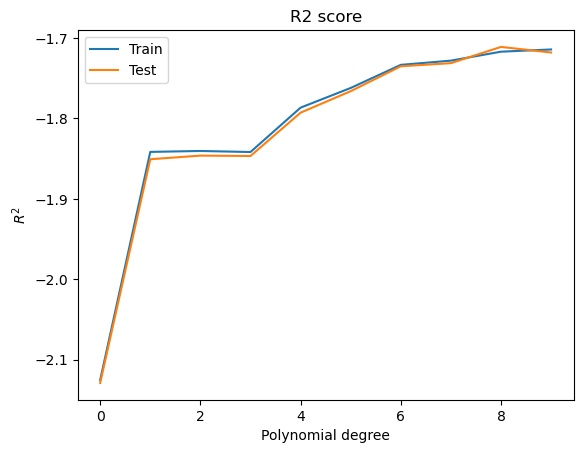

In [64]:
# Plot R2 scores as function of poly. degree 
plt.figure()
plt.plot(degrees, train_r2, label="Train")
plt.plot(degrees, test_r2, label="Test")
plt.legend()
plt.title("R2 score")
plt.xlabel("Polynomial degree")
plt.ylabel("$R^2$")
#plt.savefig(FIGURES_DIR / "part_a_R2.png")

In [ ]:
# Now plot the beta parameters 
plt.figure()
for degree in degrees:
    plt.bar(
            range(beta_arr[degree].size),  # indices
            beta_arr[degree],
            label=f"{degree=}",
    )
plt.legend()
plt.xticks(np.arange(plt.xlim()[1], step=2))
plt.title("Beta parameters")
plt.xlabel("$i$")
plt.ylabel(r"$\beta_i$")
#plt.savefig(FIGURES_DIR / "part_a_beta_params.png")

# Implementing task b) to terrain data

In [ ]:
def MSE_Ridge_beta_R2(X_train, X_test, y_train, y_test, lamb):
    """Performs Ridge regression and returns the MSE, R2, and beta values for each lambda value in lamb."""
    mse_test = np.zeros(len(lamb))
    mse_train = np.zeros(len(lamb))
    r2_train = np.zeros(len(lamb))
    r2_test = np.zeros(len(lamb))
    beta = []

    I = np.identity(X_train.shape[1])
    for i in range(len(lamb)):
        # Make ridge regression
        beta_rid = np.linalg.pinv(X_train.T @ X_train + lamb[i] * I) @ X_train.T @ y_train

        # Make prediction
        y_tilde = X_train @ beta_rid
        y_predict = X_test @ beta_rid

        # Compute MSE, beta and R2 values
        mse_train[i] = MSE(y_train, y_tilde)
        mse_test[i] = MSE(y_test, y_predict)
        beta.append(beta_rid)
        r2_train[i] = R2_score(y_train, y_tilde)
        r2_test[i] = R2_score(y_test, y_predict)
    return mse_train, mse_test, beta, r2_train, r2_test


# PARAMETERS
n = 1000  # number of data points
maxdegree = 6  # max polynomial degree for plotting
lmbda_vals = np.linspace(0.0001, 1, 50)
noise_std = 1
"""
# Figure output directory
RESULTS_DIR = Path("../results").resolve()
FIGURES_DIR = RESULTS_DIR / "figures"

# Create them if they dont exist
if not RESULTS_DIR.exists():
    RESULTS_DIR.mkdir()

if not FIGURES_DIR.exists():
    FIGURES_DIR.mkdir()
"""


# Make lists which will contain plot data
degrees = np.arange(0, maxdegree, 1)
mse_train_arr = []
mse_test_arr = []
beta_arr = []
r2_train_arr = []
r2_test_arr = []

# Iterate through all the different polynomial degrees
for degree in degrees:
    # tell the model what degree of polynomial we want
    polynomial_model = PolynomialFeatures(degree)

    # use the package to create a design matrix for a second degree polynomial
    # by converting x to a column vector 
    X = polynomial_model.fit_transform(x_mesh)
    # Split in training and test data
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

    # Scale data
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Perform ridge regression
    mse_train, mse_test, beta, r2_train, r2_test = MSE_Ridge_beta_R2(
            X_train_scaled, X_test_scaled, z_train, z_test, lmbda_vals)
    mse_train_arr.append(mse_train)
    mse_test_arr.append(mse_test)
    beta_arr.append(beta)
    r2_train_arr.append(r2_train)
    r2_test_arr.append(r2_test)

In [ ]:
# Plot MSE's
figsize = (8, 5)
fig = plt.figure(figsize=figsize)
fig.suptitle("MSE values")
for degree in degrees:
    plt.subplot(3, 2, degree + 1)
    plt.title(f"{degree=}")
    plt.plot(lmbda_vals, mse_train_arr[degree], label=f"Train")
    plt.plot(lmbda_vals, mse_test_arr[degree], label=f"Test")
    plt.legend()
    plt.xlabel(r"$\lambda$")
    plt.ylabel("MSE")
    plt.xscale("log")
plt.tight_layout()

In [ ]:
# Plot R2's
fig = plt.figure(figsize=figsize)
fig.suptitle("R2 scores")
for degree in degrees:
    plt.subplot(3, 2, degree + 1)
    plt.title(f"{degree=}")
    plt.plot(lmbda_vals, r2_train_arr[degree], label=f"Train")
    plt.plot(lmbda_vals, r2_test_arr[degree], label=f"Test")
    plt.legend()
    plt.xlabel(r"$\lambda$")
    plt.ylabel("$R^2$")
    plt.xscale("log")
plt.tight_layout()

In [ ]:
# Plot test MSE's in same figure
plt.figure(figsize=figsize)
plt.title("Test MSE's of polynomial degrees")
for degree in degrees[1:]:
    plt.plot(lmbda_vals, mse_test_arr[degree], label=f"{degree=}")
    plt.legend()
    plt.xlabel(r"$\lambda$")
    plt.ylabel("MSE")
    plt.xscale("log")
#plt.savefig(FIGURES_DIR / "part_b_MSE.png")

In [ ]:
# Plot test R2's in same figure
plt.figure(figsize=figsize)
plt.title("Test R2 scores of polynomial degrees")
for degree in degrees[1:]:
    plt.plot(lmbda_vals, r2_test_arr[degree], label=f"{degree=}")
    plt.legend()
    plt.xlabel(r"$\lambda$")
    plt.ylabel("$R^2$")
    plt.xscale("log")
#plt.savefig(FIGURES_DIR / "part_b_R2.png")

In [ ]:
# Print lambda with lowest MSE for each degree
print("OPTIMAL λ-VALS FOR EACH POLY. DEGREE:")
for degree in degrees:
    print(f"{degree=}: λ={lmbda_vals[np.argmin(mse_test_arr[degree])]}")

# Implementing task c) to terrain data